# Keyrir Strætó of hratt?: Samanburður keyrsluhraðagagna frá Strætó API-inu við hámarkshraðagögn

_**Árni Dagur Guðmundsson**: arni@dagur.eu | Menntaskólinn við Hamrahlíð_

## Inngangur:

### Open Street Map

In [1]:
from straeto.data import get_osm_data

#get_osm_data(verbose=True)

In [2]:
!printf 'osm-data:\n' && ls osm-data/ && printf '\nosm-data/output:\n' && ls osm-data/output

osm-data:
gis_osm_roads_free_1.cpg  gis_osm_roads_free_1.prj  gis_osm_roads_free_1.shx
gis_osm_roads_free_1.dbf  gis_osm_roads_free_1.shp  output

osm-data/output:
extracted_roads.cpg  extracted_roads.shx     no_extracted_roads.shp
extracted_roads.dbf  no_extracted_roads.cpg  no_extracted_roads.shx
extracted_roads.prj  no_extracted_roads.dbf
extracted_roads.shp  no_extracted_roads.prj


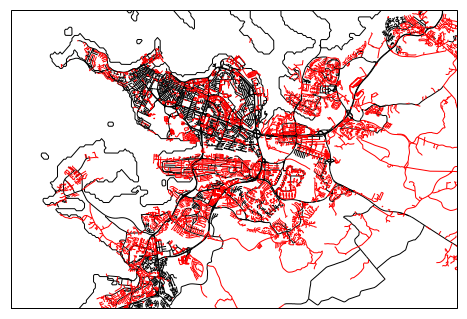

In [3]:
from straeto import straeto
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = straeto.get_map(region='reykjavik', res='f', zoom=1.5)

ax = straeto.add_shapefile(ax, 'osm-data/output/extracted_roads.shp')
ax = straeto.add_shapefile(ax, 'osm-data/output/no_extracted_roads.shp', edgecolor='red')

plt.show()

### API
Falið í kóða heimasíðu Strætó má finna API (forritaskil) sem geyma ýmsar upplýsingar um staka strætisvagna í rauntíma. Strætó appið notar þetta API meðal annars til að sýna staðsetningu strætisvagna á korti. Ég bjó til einfaldan Python pakka sem kallar á API-ið og spýtir út niðurstöðunum í JSON. Hér fyrir neðan sést niðurstaða einfalds kalls:

In [4]:
from straeto import api
api.getBusPositionsFor(["1", "55"])[0]

{'deviceNumber': 34,
 'route': '1-A',
 'gpsTime': '180530173647',
 'lat': 64.1467683333333,
 'lon': -21.93055,
 'speed': 14.73,
 'heading': 292.78,
 'gpsFix': 2,
 'routeNumber': '1',
 'lastStop': 90000054,
 'nextStop': 90000055,
 'pingCode': 6}

Eins og sést býður API-ið upp á breiddargráðu (_lat_), og lengdargráðu (_lon_). Því er til dæmis hægt að birta staðsetningu allra strætisvagna landsins á kort líkt og svo:

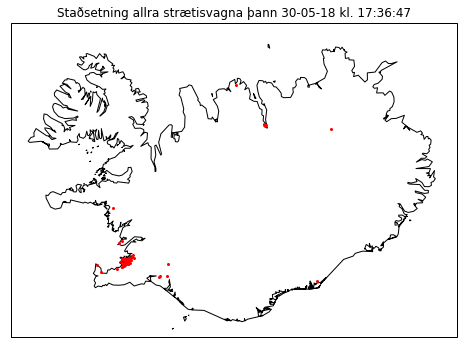

In [5]:
from datetime import datetime

fig, ax = straeto.get_map(region='iceland')

for bus in api.getAllBusPositions():
    plt.plot(bus['lon'], bus['lat'], marker='o', color='red', markersize=2,
             transform=ccrs.Geodetic())

plt.title('Staðsetning allra strætisvagna þann {}'.format(datetime.now().strftime('%d-%m-%y kl. %H:%M:%S')))
plt.show()

Hraðinn er einnig til staðar en ekki vitum við þó hvaða mælieining notuð er til þess að mæla hann.

$k\cdot v_{api} = v \Rightarrow k = \frac{v}{v_{api}}$

In [6]:
from straeto import straeto
bdict, p_bdict = straeto.getConsecutiveBuses(ratio=0.5)

print(len(bdict),len(p_bdict))

88 88


In [7]:
from geopy.distance import geodesic
from datetime import datetime as dt
G = []
B = []
Ks = []
for key in bdict:
    bus = bdict[key]; p_bus = p_bdict[key]
    t_1 = dt.strptime(bus['gpsTime'],"%y%m%d%H%M%S"); t_2 = dt.strptime(p_bus['gpsTime'],"%y%m%d%H%M%S")
    delta_t = (t_1-t_2).total_seconds()
    delta_s = geodesic((bus['lat'], bus['lon']), (p_bus['lat'], p_bus['lon'])).km

    kmh = (delta_s/delta_t)*3600
    avg_speed = (1/2)*(bus['speed']+p_bus['speed'])

    k = kmh/avg_speed
    Ks.append(k)
    dic = {
        'speed_0': p_bus['speed'],
        'speed_1': bus['speed'],
        'delta_s': delta_s,
        'delta_t': delta_t,
        'kmh': kmh,
        'avg_speed': avg_speed,
        'route': bus['route'],
        'k': k
    }
    if 1.7 < k < 1.9:
        G.append(dic)
    else:
        B.append(dic)

print('Good:')
for i in G:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
print('Bad:')
for i in B:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
avg_k = sum(Ks)/len(Ks)
print(avg_k)


Good:
58-A | k = 83.72 / 44.69 = 1.87 | 42.78 --> 46.6
13-D | k = 21.43 / 11.29 = 1.9 | 11.34 --> 11.25
13-A | k = 24.64 / 13.1 = 1.88 | 9.09 --> 17.11
16-C | k = 29.82 / 15.72 = 1.9 | 16.15 --> 15.29
4-E | k = 69.45 / 36.67 = 1.89 | 38.39 --> 34.96
18-H | k = 45.54 / 24.64 = 1.85 | 22.59 --> 26.7
69-I | k = 14.32 / 7.65 = 1.87 | 5.44 --> 9.87
2-E | k = 52.61 / 28.07 = 1.87 | 27.25 --> 28.9
14-C | k = 17.46 / 10.02 = 1.74 | 6.1 --> 13.95
21-A | k = 26.6 / 14.95 = 1.78 | 11.83 --> 18.06
24-C | k = 16.14 / 8.7 = 1.86 | 5.19 --> 12.21
7-A | k = 14.97 / 8.0 = 1.87 | 5.15 --> 10.85
15-C | k = 69.97 / 37.43 = 1.87 | 32.21 --> 42.65
15-D | k = 30.46 / 16.28 = 1.87 | 20.42 --> 12.13
15-B | k = 24.18 / 13.71 = 1.76 | 22.87 --> 4.56
18-A | k = 72.87 / 38.41 = 1.9 | 31.89 --> 44.94
5-B | k = 63.81 / 33.62 = 1.9 | 27.03 --> 40.21
57-C | k = 80.08 / 43.0 = 1.86 | 43.59 --> 42.4
5-C | k = 43.14 / 23.37 = 1.85 | 23.12 --> 23.61
18-G | k = 27.54 / 14.74 = 1.87 | 11.28 --> 18.2
1-G | k = 81.42 / 43.7 =

## Undirbúningur gagna:
Load sqlite files:
```
pgloader 25-03-2018.db postgresql:///straeto
```
Started 22:37
```
UPDATE buses b SET maxspeed = (SELECT r.maxspeed FROM roads r ORDER BY b.geom <-> r.geom LIMIT 1);
```
Aðeins hraðara: (37-39 sec með index)
```
UPDATE buses b SET maxspeed = (SELECT r.maxspeed FROM roads r WHERE ST_Expand(b.geom, 0.012) && r.geom ORDER BY b.geom <-> r.geom LIMIT 1);
```

In [8]:
%alias sql psql straeto -c

In [9]:
sql "\dt"

            List of relations
 Schema |      Name       | Type  | Owner 
--------+-----------------+-------+-------
 public | buses           | table | arni
 public | roads           | table | arni
 public | spatial_ref_sys | table | arni
(3 rows)



In [10]:
#sql "ALTER TABLE buses ADD COLUMN geom Geometry(Point, 4326);"

In [11]:
#sql "UPDATE buses SET geom=ST_SetSrid(ST_MakePoint(lon, lat), 4326);"

In [12]:
#sql "CREATE INDEX buses_gix ON buses USING gist(geom);"

In [13]:
#sql "VACUUM ANALYZE;"

In [14]:
#sql "ALTER TABLE buses ADD maxspeed integer;"

## Úrvinnsla gagna:

In [44]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql

connection = pg.connect(database='straeto',
                        # Location of .s.PGSQL.5432 file;
                        # try host='/tmp' if you get an error.
                        host='/var/run/postgresql')
df = pd_sql.read_sql("SELECT gps_time, route_number, lat, lon, speed, maxspeed FROM buses;", connection)

In [45]:
df['gps_time'] = pd.to_datetime(df['gps_time'], format='%y%m%d%H%M%S')
df['speed'] = df['speed']*1.85

In [46]:
df = df.set_index('gps_time')

In [47]:
df.head(3)

,route_number,lat,lon,speed,maxspeed
gps_time,,,,,
2018-03-24 23:58:05,12,64.1280,-21.9471,0.0000,0
2018-03-24 23:58:07,3,64.1330,-21.8965,50.9675,60
2018-03-24 23:58:06,7,64.1689,-21.6923,19.9615,30


In [48]:
df = df.query('maxspeed > 0')
df['ratio'] = df['speed']/df['maxspeed']

In [49]:
over = df.query('maxspeed < speed')
under = df.query('maxspeed >= speed')

In [50]:
df.head(8)

,route_number,lat,lon,speed,maxspeed,ratio
gps_time,,,,,,
2018-03-24 23:58:07,3,64.1330,-21.8965,50.9675,60,0.849458
2018-03-24 23:58:06,7,64.1689,-21.6923,19.9615,30,0.665383
2018-03-24 23:58:05,15,64.1455,-21.9677,28.3235,30,0.944117
2018-03-24 23:58:05,12,64.1243,-21.8482,61.3645,60,1.022742
2018-03-24 23:58:05,15,64.1628,-21.7282,27.5465,50,0.550930
2018-03-24 23:58:05,3,64.1455,-21.9245,22.2555,30,0.741850
2018-03-24 23:58:08,18,64.1287,-21.7731,68.9495,80,0.861869
2018-03-24 23:58:07,28,64.1101,-21.8880,24.6790,50,0.493580


In [51]:
print(len(over), len(under), round(len(over)*100/len(under), 1))

64434 331371 19.4


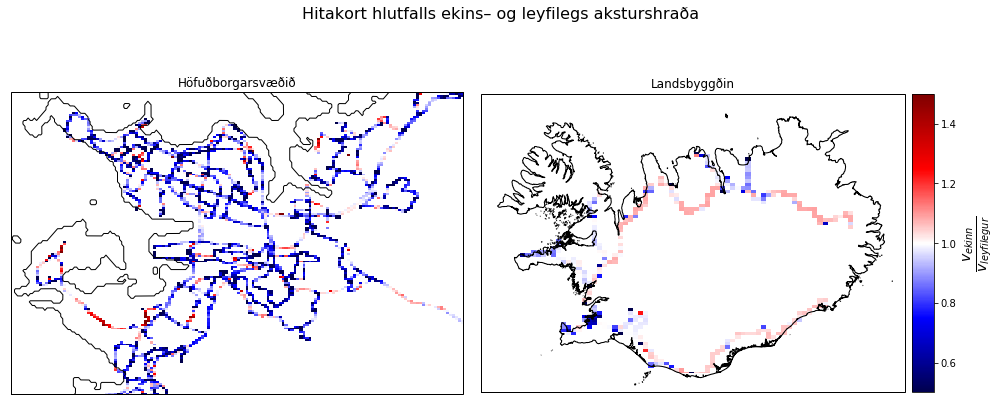

In [52]:
%matplotlib inline
import numpy as np

x = df['lon']
y = df['lat']
ratios = df['ratio']

fig, (ax, ax2) = straeto.get_map(region=[['reykjavik', 1.15], 'iceland'], res='f',
                                 figsize=(14, 7), shape=(1, 2))
# The heatmap itself
im = straeto.add_heatmap(ax, x, y, ratios, bins=4000, statistic='median')
im = straeto.add_heatmap(ax2, x, y, ratios, bins=65, statistic='median')
# The colourbar
straeto.add_colorbar(fig, ax2, im, label='$\\frac{v_{ekinn}}{v_{leyfilegur}}$')

fig.suptitle('Hitakort hlutfalls ekins– og leyfilegs aksturshraða', size=16)
ax.set_title('Höfuðborgarsvæðið')
ax2.set_title('Landsbyggðin')

fig.tight_layout()
plt.subplots_adjust(top=1)
plt.show()

In [53]:
df.groupby(['route_number']).median().sort_values(by=['ratio'], ascending=False)

,lat,lon,speed,maxspeed,ratio
route_number,,,,,
56,65.59370,-16.49590,94.68300,90,1.060564
51,63.95780,-20.98780,85.57175,90,0.979328
73,64.01220,-20.74350,86.42275,90,0.977006
57,64.54120,-21.73400,84.69300,90,0.976800
72,64.02790,-20.73090,86.32100,90,0.976594
52,63.94420,-20.99930,82.84300,90,0.972175
59,65.06510,-21.74570,86.52450,90,0.965330
78,65.93835,-18.40560,79.35575,90,0.950694
58,64.75520,-22.24960,84.85950,90,0.948228
